<a href="https://colab.research.google.com/github/LikeWind99/colab/blob/main/spark_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 使用spark进行mini_newsgroups数据集的分类

本次课程设计我们使用Google提供的云平台colab进行，课程设计的主要内容是使用pyspark和spark-nlp对经典的新闻数据集`mini_newsgroups`进行分类。

Colaboratory 简称“Colab”，是 Google Research 团队开发的一款产品。在 Colab 中，任何人都可以通过浏览器编写和执行任意 Python 代码。它尤其适合机器学习、数据分析和教育目的。从技术上来说，Colab 是一种托管式 Jupyter 笔记本服务。用户无需设置，就可以直接使用，同时还能获得 GPU 等计算资源的免费使用权限。

Google对colab进行了各种优化与适配，因此在配置开发环境时会十分方便，相较于在本地从头配置开发环境，使用colab无疑是更加方便的，同时由于其服务器在国外，当我们访问外网下载数据时，colab的下载速度很快的，综合考虑下本次课程项目全程在colab云端平台上进行。


### 安装java，pyspark，spark-nlp以及它们依赖的库

In [ ]:
## install java, pyspark and spark-nlp 
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip3 install --ignore-installed pyspark

# Install Spark NLP
! pip3 install --ignore-installed spark-nlp

openjdk version "1.8.0_352"
OpenJDK Runtime Environment (build 1.8.0_352-8u352-ga-1~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.352-b08, mixed mode)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 40 kB/s 
     |████████████████████████████████| 199 kB 70.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=e729e30d3e2b087a316dee772c36038751a95ad88d84c6767e5d005efb5b95ec
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 453 kB 5.0 MB/s 


### 下载数据集
这里直接使用Linux的`wget`指令下载已有的`mini_newsgroups`数据集。原本是想使用分布式数据爬虫`scrapy-redis`在腾讯新闻网下载时事新闻的，但是colab并不支持多开虚拟机，因此放弃了这个想法，直接使用已经整理好的`mini_newsgroups`数据集。

In [ ]:
! mkdir -p data
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/mini_newsgroups.tar.gz

--2022-12-27 08:03:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/mini_newsgroups.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1860687 (1.8M) [application/x-httpd-php]
Saving to: ‘mini_newsgroups.tar.gz’

mini_newsgroups.tar 100%[===================>]   1.77M  --.-KB/s    in 0.07s   

2022-12-27 08:03:22 (25.7 MB/s) - ‘mini_newsgroups.tar.gz’ saved [1860687/1860687]



In [ ]:
# 解压数据到data目录下
! tar xzf mini_newsgroups.tar.gz -C ./data/

In [ ]:
## import revelant pacakages
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyspark.sql.types import *
from pyspark.sql.functions import expr
from pyspark.sql import Row
from pyspark.ml import Pipeline

import sparknlp
from sparknlp import DocumentAssembler, Finisher
from sparknlp.annotator import *

%matplotlib inline

# 此处使用sparknlp.start()来开启一个spark session
spark = sparknlp.start()

我们将构建一个分类器来识别文档来自哪个新闻组。但是新闻组在文档的标题中有提及，因此我们需要删除这些新闻组，仅保留文本。

In [ ]:
# 创建pattern
HEADER_PTN = re.compile(r'^[a-zA-Z-]+:.*')

def remove_header(path_text_pair):
    path, text = path_text_pair
    lines = text.split('\n')
    line_iterator = iter(lines)
    while HEADER_PTN.match(next(line_iterator)) is not None:
        pass
    return path, '\n'.join(line_iterator)

In [ ]:
#####################################################################################################################
# SparkContext是spark功能的主要入口。其代表与spark集群的连接，能够用来在集群上创建RDD、累加器、广播变量。
# 每个JVM里只能存在一个处于激活状态的SparkContext，在创建新的SparkContext之前必须调用stop()来关闭之前的SparkContext。 
#####################################################################################################################
path = os.path.join('data', 'mini_newsgroups', '*')
texts = spark.sparkContext.wholeTextFiles(path).map(remove_header)

# 设置输入数据的数据类型
schema = StructType([
    StructField('path', StringType()),
    StructField('text', StringType()),
])

# 创建DataFrame
texts = spark.createDataFrame(texts, schema=schema) \
    .withColumn('newsgroup', expr('split(path, "/")[4]')) \
    .persist()

In [ ]:
# 查看一下数据的结构
texts.groupBy('newsgroup').count().collect()

[Row(newsgroup='comp.windows.x', count=100),
 Row(newsgroup='misc.forsale', count=100),
 Row(newsgroup='rec.sport.hockey', count=100),
 Row(newsgroup='rec.sport.baseball', count=100),
 Row(newsgroup='comp.os.ms-windows.misc', count=100),
 Row(newsgroup='comp.sys.ibm.pc.hardware', count=100),
 Row(newsgroup='comp.graphics', count=100),
 Row(newsgroup='comp.sys.mac.hardware', count=100),
 Row(newsgroup='rec.motorcycles', count=100),
 Row(newsgroup='rec.autos', count=100),
 Row(newsgroup='alt.atheism', count=100),
 Row(newsgroup='sci.crypt', count=100),
 Row(newsgroup='talk.politics.guns', count=100),
 Row(newsgroup='talk.politics.misc', count=100),
 Row(newsgroup='soc.religion.christian', count=100),
 Row(newsgroup='talk.religion.misc', count=100),
 Row(newsgroup='talk.politics.mideast', count=100),
 Row(newsgroup='sci.electronics', count=100),
 Row(newsgroup='sci.space', count=100),
 Row(newsgroup='sci.med', count=100)]

可以看到我们的数据：一共20个分类，每个分类100条新闻

In [ ]:
print(texts.first()['path'])
print(texts.first()['newsgroup'])
print(texts.first()['text'])

file:/content/data/mini_newsgroups/alt.atheism/53633
alt.atheism
In article <1993Apr16.223250.15242@ncsu.edu> aiken@news.ncsu.edu (Wayne NMI Aiken) writes:
>JSN104@psuvm.psu.edu wrote:
>: YOU BLASHEPHEMERS!!! YOU WILL ALL GO TO HELL FOR NOT BELIEVING IN GOD!!!!  BE
>: PREPARED FOR YOUR ETERNAL DAMNATION!!!
>
>Did someone leave their terminal unattended again?
>
>--
>
>Holy Temple of Mass  $   >>> slack@ncsu.edu <<<    $  "My used underwear
>   Consumption!      $                             $   is legal tender in
>PO Box 30904         $     BBS: (919) 782-3095     $   28 countries!"
>Raleigh, NC  27622   $  Warning: I hoard pennies.  $     --"Bob"

Probably not! The jesus freak's post is probably JSN104@PSUVM. Penn State
is just loaded to the hilt with bible bangers. I use to go there *vomit* and
it was the reason I left. They even had a group try to stop playing 
rock music in the dining halls one year cuz they deemed it satanic. Kampus
Krusade for Khrist people run the damn place for

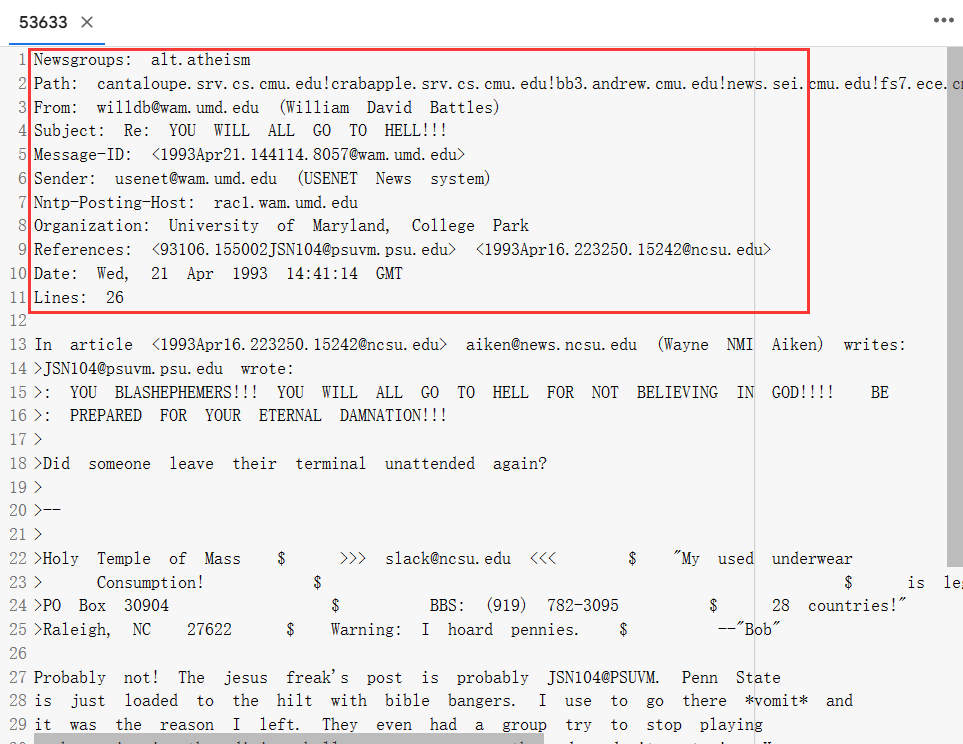

可以看到，经过我们的预处理，已经把原始文本中附带的信息头给去除掉了，现在新闻中只剩下最原始的文本信息

In [ ]:
# 此处我们创建一个pipeline，对数据再进行一系列的分词，清洗，最后送入分类器进行分类
assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('document')
sentence = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentences")
tokenizer = Tokenizer()\
    .setInputCols(['sentences'])\
    .setOutputCol('token')
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['token'])\
    .setOutputCol('lemma')
normalizer = Normalizer()\
    .setCleanupPatterns([
        '[^a-zA-Z.-]+', 
        '^[^a-zA-Z]+', 
        '[^a-zA-Z]+$',
    ])\
    .setInputCols(['lemma'])\
    .setOutputCol('normalized')\
    .setLowercase(True)
finisher = Finisher()\
    .setInputCols(['normalized'])\
    .setOutputCols(['normalized'])\
    .setOutputAsArray(True)
pipeline = Pipeline().setStages([
    assembler, sentence, tokenizer, 
    lemmatizer, normalizer, finisher
]).fit(texts)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [ ]:
processed = pipeline.transform(texts).persist()

In [ ]:
# output the number of data length
print(processed.count())

2000


TF-IDF构建的文档向量是文档分类和回归中使用的最常见的特征类型。然而，使用这样的功能有一些困难。根据语料库的大小，我们得到的特征可能会超过几万个，而且对于任何一篇新闻应该都只有几百到几千个非零特征，所以创建整个词向量矩阵是不现实的。此处我们通过创建特征矩阵的稀疏表示来处理，其中省略count为0的值。

In [ ]:
# 构建词向量，并计算TF-IDF
from pyspark.ml.feature import CountVectorizer, IDF

count_vectorizer = CountVectorizer(
    inputCol='normalized', outputCol='tf', minDF=10)
idf = IDF(inputCol='tf', outputCol='tfidf', minDocFreq=10)

bow_pipeline = Pipeline(stages=[count_vectorizer, idf])
bow_pipeline = bow_pipeline.fit(processed)

bows = bow_pipeline.transform(processed)

In [ ]:
bows.limit(5).toPandas()[['tf', 'tfidf']]

,tf,tfidf
0,"(9.0, 6.0, 4.0, 1.0, 1.0, 1.0, 3.0, 5.0, 0.0, ...","(0.6576351108883792, 0.5491156405729176, 0.526..."
1,"(2.0, 7.0, 3.0, 3.0, 4.0, 1.0, 2.0, 1.0, 5.0, ...","(0.14614113575297316, 0.6406349140017372, 0.39..."
2,"(10.0, 32.0, 15.0, 12.0, 12.0, 2.0, 12.0, 5.0,...","(0.7307056787648658, 2.9286167497222273, 1.976..."
3,"(10.0, 11.0, 2.0, 2.0, 5.0, 3.0, 4.0, 3.0, 4.0...","(0.7307056787648658, 1.0067120077170157, 0.263..."
4,"(1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, ...","(0.07307056787648658, 0.0915192734288196, 0.0,..."


因为我们要做的是文本分类，而这里有很多类别，不同类别的新闻有不同的关键词，此处随机生成一些词汇并在我们处理好的数据中查询，看看数据分布的情况。这里我们使用spark-nlp提供的`RegexMatcher`来匹配关键字。 

In [ ]:
%%writefile scifi_rules.tsv
\w+(lith|ant|an)ium,mineral
(alien|cosmic|quantum|dimension(al)?),space_word

Writing scifi_rules.tsv


In [ ]:
# 使用正则表达式的方式进行文本查找
regex_matcher = RegexMatcher() \
    .setOutputCol("regex") \
    .setExternalRules('./scifi_rules.tsv', ',')

In [ ]:
regex_finisher = Finisher()\
    .setInputCols(['regex'])\
    .setOutputCols(['regex'])\
    .setOutputAsArray(True)

regex_rule_pipeline = Pipeline().setStages([
    assembler, regex_matcher, regex_finisher
]).fit(texts)

regex_matches = regex_rule_pipeline.transform(texts)

In [ ]:
regex_matches.orderBy(expr('size(regex)').desc())\
    .limit(5).toPandas()[['newsgroup', 'regex']]

,newsgroup,regex
0,talk.politics.guns,"[alien, alien, alien, alien, alien, alien, alien]"
1,comp.graphics,"[dimensional, dimension, dimensional, dimension]"
2,sci.space,"[quantum, quantum, cosmic]"
3,sci.space,"[cosmic, cosmic, cosmic]"
4,sci.med,"[dimensional, alien, dimensional]"


可以看到我们生成的关键字在相应的文章中是可以找到的

In [ ]:
# 去除无意义的停用词
from pyspark.ml.feature import StopWordsRemover

sw_remover = StopWordsRemover() \
    .setInputCol("normalized") \
    .setOutputCol("filtered") \
    .setStopWords(StopWordsRemover.loadDefaultStopWords("english"))

接下来展示如何更新一下我们的pipeline，仅作为演示，项目实际使用的pipeline将从头构建，我们使用`setStages`方法来更新pipeline，将每一步需要完成的步骤放入stage列表中即可。

In [ ]:
# 更新我们的pipeline
count_vectorizer = CountVectorizer(inputCol='filtered', 
    outputCol='tf', minDF=10)
idf = IDF(inputCol='tf', outputCol='tfidf', minDocFreq=10)

pipeline = Pipeline() \
    .setStages([
        assembler, 
        sentence, 
        tokenizer, 
        lemmatizer, 
        normalizer, 
        finisher, 
        sw_remover,
        count_vectorizer,
        idf
    ]) \
    .fit(texts)

In [ ]:
features = pipeline.transform(texts).persist()

In [ ]:
features.printSchema()

root
 |-- path: string (nullable = true)
 |-- text: string (nullable = true)
 |-- newsgroup: string (nullable = true)
 |-- normalized: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf: vector (nullable = true)
 |-- tfidf: vector (nullable = true)



In [ ]:
pipeline.stages

[DocumentAssembler_e24082572e97,
 SentenceDetector_7eebabc51803,
 REGEX_TOKENIZER_2b61af83b6d9,
 LEMMATIZER_c62ad8f355f9,
 NORMALIZER_f0ca58f39a04,
 Finisher_8f7b6f94f328,
 StopWordsRemover_6379bd8e6251,
 CountVectorizerModel: uid=CountVectorizer_65e7a8e33c48, vocabularySize=3033,
 IDFModel: uid=IDF_13dbab20cb6c, numDocs=2000, numFeatures=3033]

In [ ]:
cv_model = pipeline.stages[-2]

接下来我们可以查看一下我们构建的词汇表的信息，包括词汇表的大小，以及出现最多的词汇是哪些

In [ ]:
# 打印词汇表的大小
len(cv_model.vocabulary)

3033

In [ ]:
# 查看词汇表的一些信息
cv_model.vocabulary[:10]

['write', 'one', 'use', 'get', 'article', 'say', 'know', 'x', 'make', 'dont']

In [ ]:
tf = features.select('tf').toPandas()
tf = tf['tf'].apply(lambda sv: sv.toArray())
mean_tf = pd.Series(tf.mean(), index=cv_model.vocabulary)

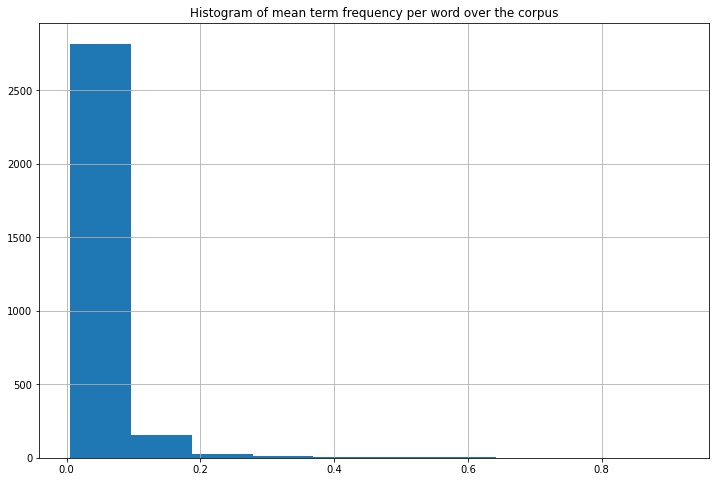

In [ ]:
plt.figure(figsize=(12, 8))
mean_tf.hist(bins=10)
plt.title('Histogram of mean term frequency per word over the corpus')
plt.show()

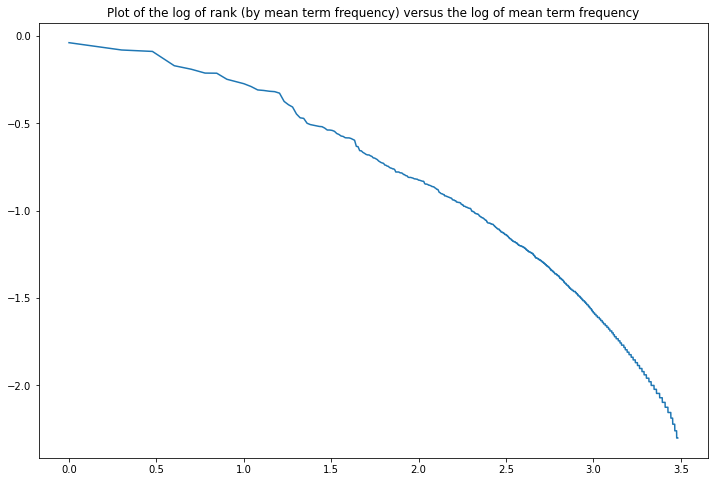

In [ ]:
plt.figure(figsize=(12, 8))
ranks = np.arange(len(mean_tf)) + 1
plt.plot(np.log10(ranks), np.log10(mean_tf.values))
plt.title('Plot of the log of rank (by mean term frequency) versus the log of mean term frequency')
plt.show()

分割数据，分成测试集和训练集

In [ ]:
train, test = texts.randomSplit([0.8, 0.2], seed=123)

去除停用词

In [ ]:
stopwords = set(StopWordsRemover.loadDefaultStopWords("english"))

上面我们已经演示了一些方法的具体调用细节，并查看了每一步的输出，接下来直接在整个数据集上使用这些方法即可

In [ ]:
sw_remover = StopWordsRemover() \
    .setInputCol("normalized") \
    .setOutputCol("filtered") \
    .setStopWords(list(stopwords))

count_vectorizer = CountVectorizer(inputCol='filtered', 
    outputCol='tf', minDF=10)
idf = IDF(inputCol='tf', outputCol='tfidf', minDocFreq=10)

text_processing_pipeline = Pipeline(stages=[
        assembler, 
        sentence, 
        tokenizer, 
        lemmatizer, 
        normalizer, 
        finisher, 
        sw_remover,
        count_vectorizer,
        idf
    ])

In [ ]:
from pyspark.ml.feature import IndexToString, StringIndexer
from pyspark.ml.classification import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *

这里使用最简单的朴素贝叶斯的方法来进行分类

In [ ]:
label_indexer = StringIndexer(inputCol='newsgroup', outputCol='label').fit(texts)
naive_bayes = NaiveBayes(featuresCol='tfidf')
prediction_deindexer = IndexToString(inputCol='prediction', outputCol='pred_newsgroup', 
                                     labels=label_indexer.labels)

pipeline = Pipeline(stages=[
    text_processing_pipeline, label_indexer, naive_bayes, prediction_deindexer
])

构建模型

In [ ]:
model = pipeline.fit(train)

分别在测试集和训练集上查看模型的效果

In [ ]:
train_predicted = model.transform(train)
test_predicted = model.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(metricName='f1')

In [ ]:
print('f1', evaluator.evaluate(train_predicted))

f1 0.9368578470322438


In [ ]:
print('f1', evaluator.evaluate(test_predicted))

f1 0.6096141991442257


此处我们使用f1分数来评判最终模型的好坏，因为F1分数是准确度和召回率的调和平均值。可以看到我们的模型在训练集上得到了0.937的分数，然而在测试集上仅仅得到0.610的分数，可能是我们的模型过拟合了。